# NMD on raw counts

- NMD-3b & NMD-T
- Hyperparameter search (latent dimension & momentum parameter beta)
- on raw counts

## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [2]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 74.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 233.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 217.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 128.5 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 120.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86846 sha256=9cbccd9dec41fc4b3d

In [4]:
!pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.4/553.4 kB 5.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import warnings
warnings.filterwarnings("ignore")

In [6]:
import importlib

## Preprocessing
### Read data

In [7]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [8]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [9]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [10]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1255
True       71
Name: outlier, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

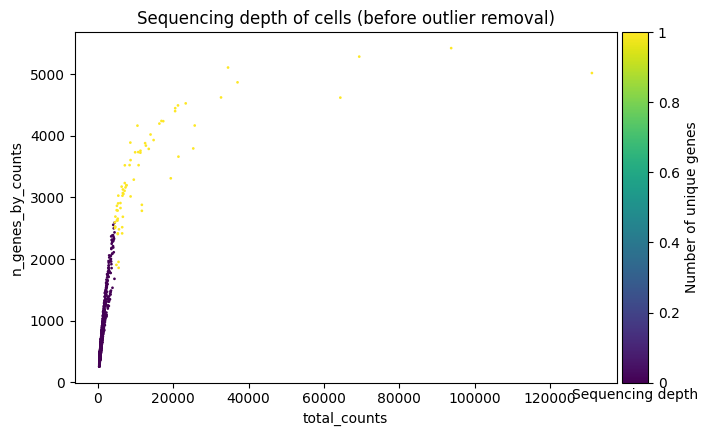

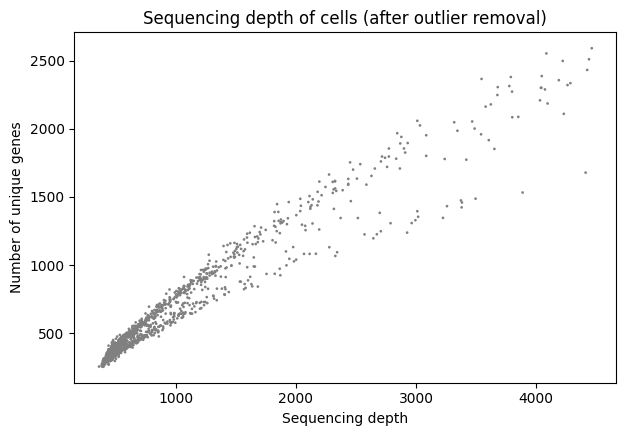

In [11]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [12]:
data_gene.layers["counts"] = data_gene.X.copy()

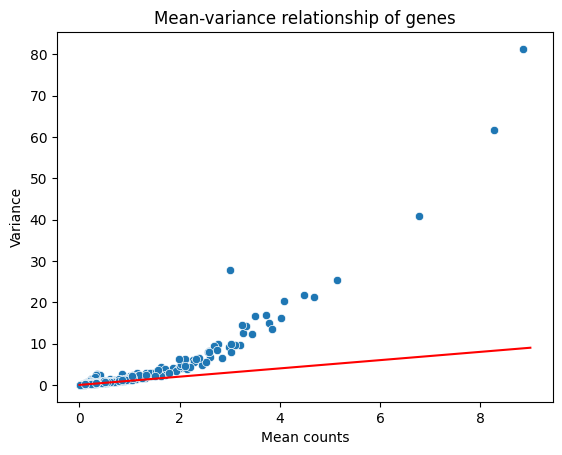

In [13]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [14]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

<Axes: xlabel='nb_mean', ylabel='Count'>

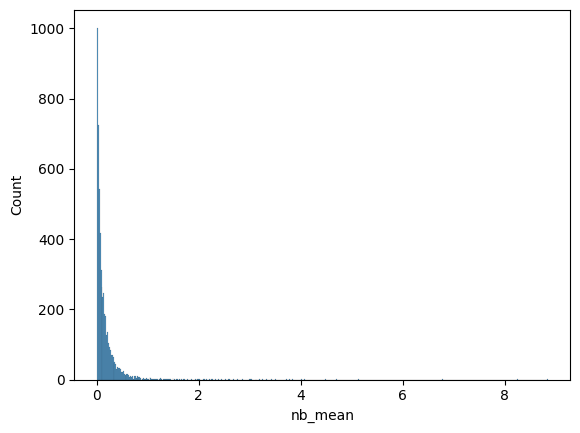

In [15]:
sns.histplot(data_gene.var["nb_mean"])

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

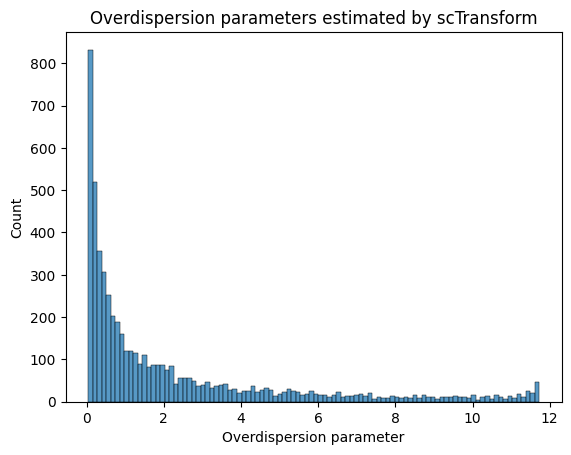

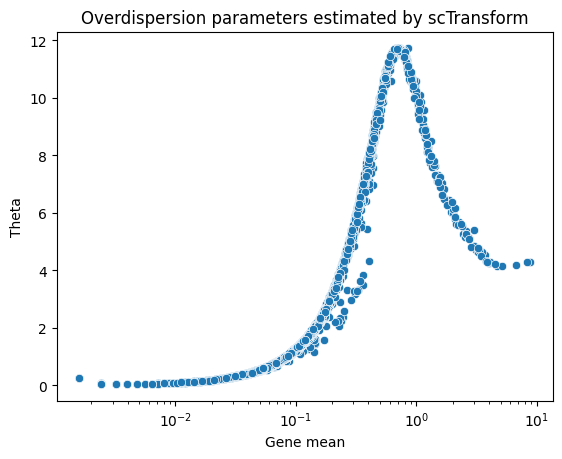

In [17]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

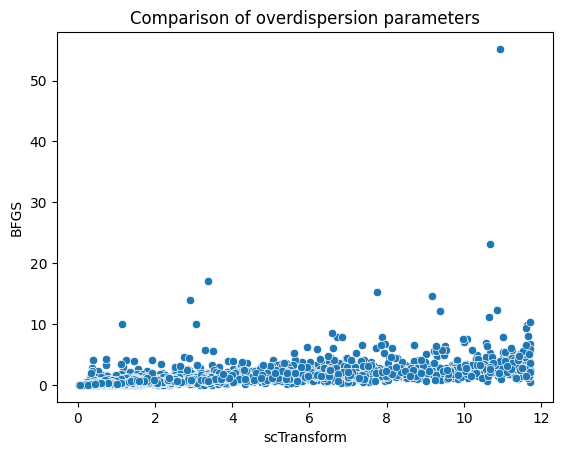

Correlation: [[1.        0.6281849]
 [0.6281849 1.       ]]


In [18]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [19]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [20]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

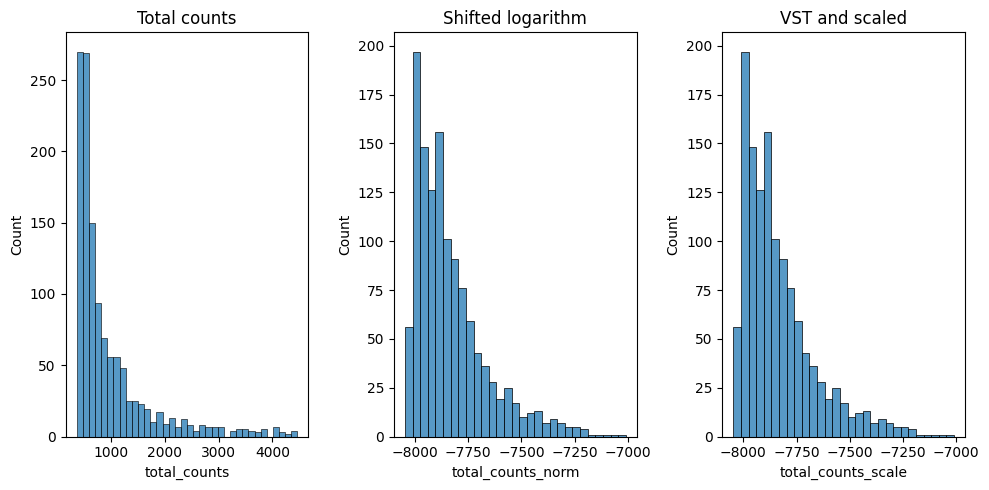

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [22]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5425
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [23]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

## Parameter search: NMD

In [24]:
importlib.reload(cs)

<module 'tools.countsplit' from '/dss/dsshome1/07/di35buw/NMD/BacSC_Moba/tools/countsplit.py'>

In [25]:
data_layer = "counts"

In [26]:
ks_2_check = [15, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.6, 0.7, 0.8, 0.9, 0.95]

In [27]:
select_cs_results = cs.select_nmd_t_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 7
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################

In [28]:
select_cs_results

,k,beta,loss
0,15,0.60,978.846635
1,15,0.70,979.996256
2,15,0.80,980.909440
3,15,0.90,980.337434
4,15,0.95,993.763089
5,12,0.60,966.666380
6,12,0.70,967.245951
7,12,0.80,967.980644
8,12,0.90,965.718092
9,12,0.95,981.447173


<Axes: xlabel='k', ylabel='loss'>

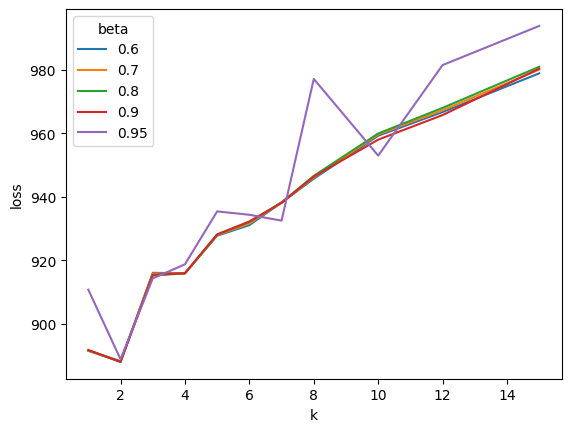

In [29]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [30]:
select_cs_3b_results = cs.select_3b_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## 

In [34]:
select_cs_3b_results.sort_values(by="loss")

,k,beta,loss,algorithm
45,2,0.60,888.252016,3B-NMD
46,2,0.70,888.259013,3B-NMD
47,2,0.80,888.973477,3B-NMD
50,1,0.60,891.593840,3B-NMD
51,1,0.70,891.968833,3B-NMD
48,2,0.90,892.457062,3B-NMD
33,5,0.90,897.296662,3B-NMD
38,4,0.90,897.491610,3B-NMD
43,3,0.90,897.586045,3B-NMD
52,1,0.80,903.827958,3B-NMD


<Axes: xlabel='k', ylabel='loss'>

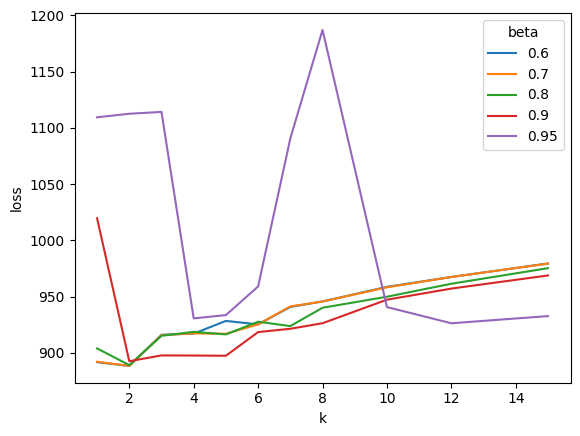

In [31]:
sns.lineplot(data=select_cs_3b_results, x="k", y="loss", hue="beta", palette="tab10")

In [32]:
select_cs_3b_results["algorithm"] = "3B-NMD"
select_cs_results["algorithm"] = "NMD-T"

cs_param_search = pd.concat([select_cs_3b_results, select_cs_results], axis=0)
cs_param_search.head()

,k,beta,loss,algorithm
0,15,0.60,979.371828,3B-NMD
1,15,0.70,979.298809,3B-NMD
2,15,0.80,975.205104,3B-NMD
3,15,0.90,968.727162,3B-NMD
4,15,0.95,932.585416,3B-NMD


In [59]:
# https://stackoverflow.com/questions/76404811/attributeerror-dataframe-object-has-no-attribute-iteritems
pd.DataFrame.iteritems = pd.DataFrame.items 

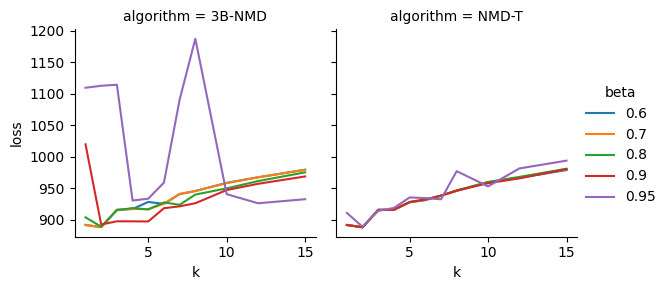

In [33]:
g = sns.FacetGrid(data=cs_param_search, col="algorithm", hue="beta", palette="tab10")
g.map(sns.lineplot, "k", "loss")
g.add_legend()
plt.show()

In [37]:
cs_param_search.sort_values(by="loss").head(15)

,k,beta,loss,algorithm
48,2,0.90,888.051152,NMD-T
45,2,0.60,888.081998,NMD-T
46,2,0.70,888.180871,NMD-T
45,2,0.60,888.252016,3B-NMD
47,2,0.80,888.255638,NMD-T
46,2,0.70,888.259013,3B-NMD
49,2,0.95,888.907766,NMD-T
47,2,0.80,888.973477,3B-NMD
51,1,0.70,891.568128,NMD-T
50,1,0.60,891.593840,3B-NMD


## NMD 3-B

In [38]:
from tools import NMD as nmd

In [39]:
k_opt_3b = 2
beta_opt_3b = 0.6
data_layer = "counts"

In [40]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b)
Theta0 = W0 @ H0

In [41]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt_3b, W0=W0, H0=H0, beta1=beta_opt_3b, tol_over_10iters=1e-5)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 64.877848] - 0.308647 secs
[1 : 64.374550] - 0.305269 secs
[2 : 63.937710] - 0.304623 secs
[3 : 63.620204] - 0.307130 secs
[4 : 63.307485] - 0.315559 secs
[5 : 63.039253] - 0.304498 secs
[6 : 62.797403] - 0.308045 secs
[7 : 62.625370] - 0.312937 secs
[8 : 62.539569] - 0.305942 secs
[9 : 62.487814] - 0.306262 secs
[10 : 62.445400] - 0.310347 secs
[11 : 62.416984] - 0.307144 secs
[12 : 62.396471] - 0.309030 secs
[13 : 62.380746] - 0.312453 secs
[14 : 62.368321] - 0.309136 secs
[15 : 62.358314] - 0.309893 secs
[16 : 62.350287] - 0.308128 secs
[17 : 62.343812] - 0.305294 secs
[18 : 62.338482] - 0.309212 secs
[19 : 62.334162] - 0.310843 secs
[20 : 62.330637] - 0.304893 secs
[21 : 62.327608] - 0.310126 secs
[22 : 62.325108] - 0.310699 secs
[23 : 62.322956] - 0.305757 secs
[24 : 62.321186] - 0.308072 secs
[25 : 62.319639] - 0.310699 secs
[26 : 62.318334] - 0.308824 secs
[27 : 62.317237] - 0.307295 

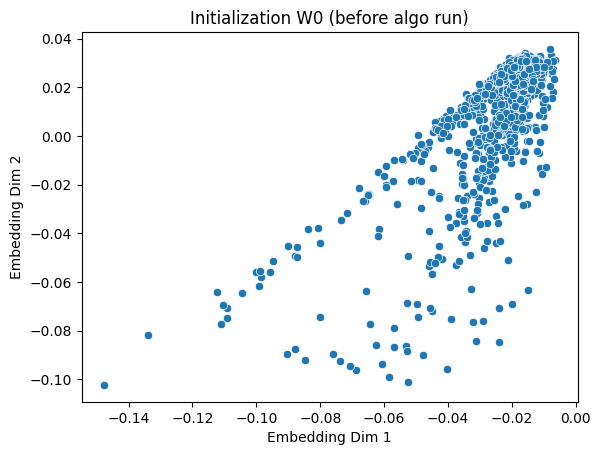

In [43]:
sns.scatterplot(x=W0[:,0], y=W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

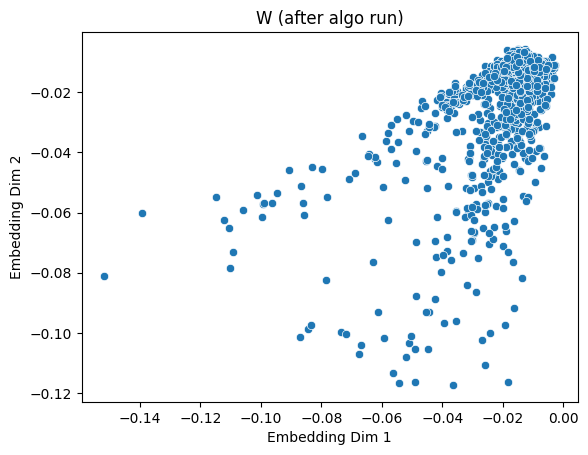

In [44]:
sns.scatterplot(x=W_3b[:,0], y=W_3b[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

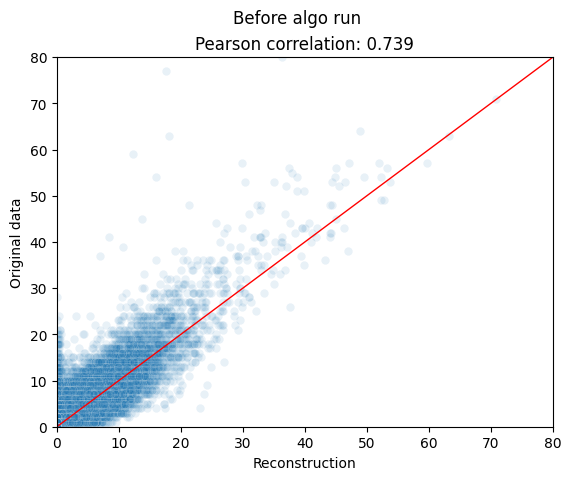

In [106]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

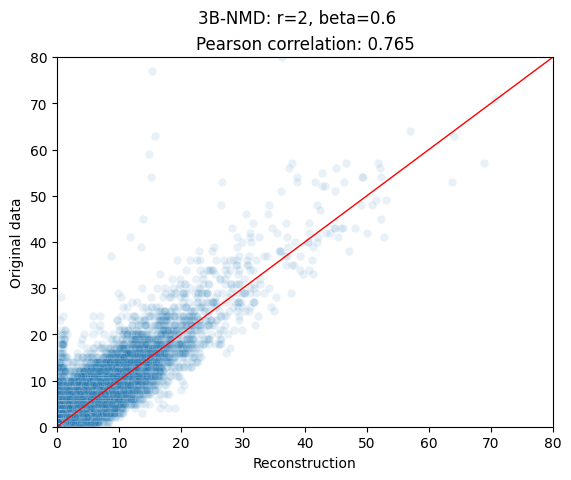

In [107]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b), X_nmd, "3B-NMD: r=2, beta=0.6", type="scatter", sample_fraction=None)

## NMD-T

In [47]:
k_opt_t = 2
beta_opt_t = 0.9

In [49]:
Theta_t, W_t, H_t, loss_t, iters_t, times_t = nmd.nmd_t(X_nmd, r=k_opt_t, W0=W0, H0=H0, beta1=beta_opt_t, tol_over_10iters=1e-4)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 65.101650] - 0.300758 secs
[1 : 64.839597] - 0.300386 secs
[2 : 64.595004] - 0.295990 secs
[3 : 64.602984] - 0.299797 secs
[4 : 64.553010] - 0.296766 secs
[5 : 64.457125] - 0.301428 secs
[6 : 64.481003] - 0.298661 secs
[7 : 64.390804] - 0.300850 secs
[8 : 64.224239] - 0.296825 secs
[9 : 63.984181] - 0.299150 secs
[10 : 63.717479] - 0.300192 secs
[11 : 63.353601] - 0.298566 secs
[12 : 63.133852] - 0.295967 secs
[13 : 62.837349] - 0.302342 secs
[14 : 62.660917] - 0.297405 secs
[15 : 62.645941] - 0.300910 secs
[16 : 62.599408] - 0.299671 secs
[17 : 62.518577] - 0.298389 secs
[18 : 62.506874] - 0.297737 secs
[19 : 62.483699] - 0.300502 secs
[20 : 62.457265] - 0.302662 secs
[21 : 62.449777] - 0.300131 secs
[22 : 62.441988] - 0.300494 secs
[23 : 62.418816] - 0.299519 secs
[24 : 62.435343] - 0.299040 secs
[25 : 62.430773] - 0.301617 secs
[26 : 62.396556] - 0.297384 secs
[27 : 62.416431] - 0.300128 s

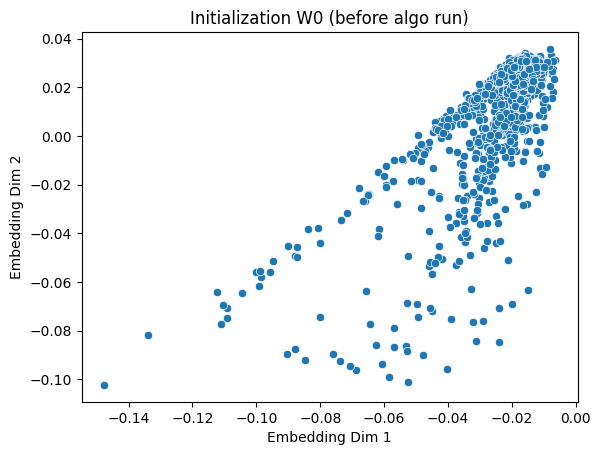

In [50]:
sns.scatterplot(x=W0[:,0], y=W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

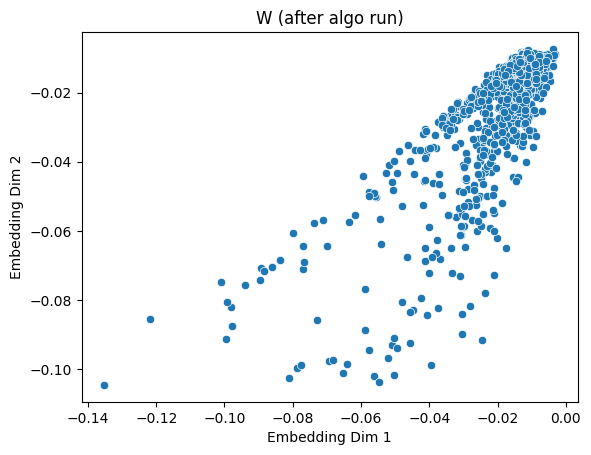

In [51]:
sns.scatterplot(x=W_t[:,0], y=W_t[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

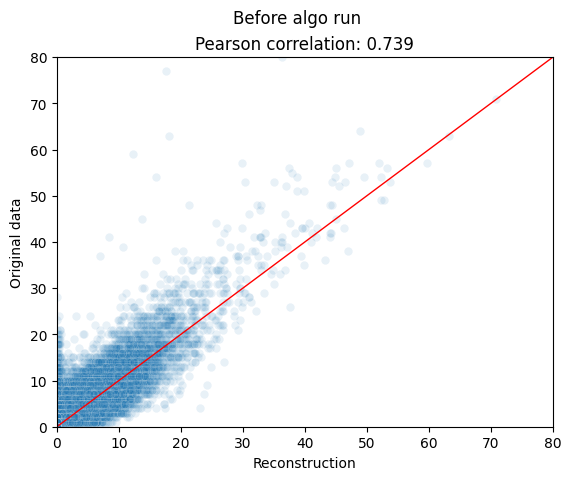

In [80]:
nmd_plot.plot_reconstruction(np.maximum(0, W0@H0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

In [83]:
spearmanr(np.maximum(0, W0@H0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4231025426184257, pvalue=0.0)

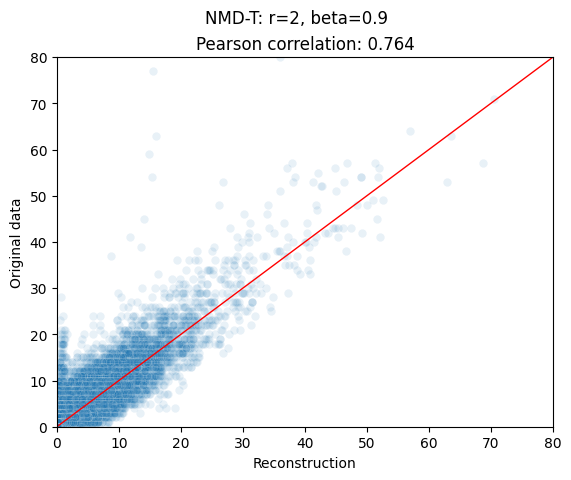

In [78]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_t), X_nmd, "After NMD-T: r=2, beta=0.9", type="scatter", sample_fraction=None)

In [85]:
spearmanr(np.maximum(0, Theta_t).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46063273984258496, pvalue=0.0)

## NMD-3B - latent dim 5

In [60]:
k_opt_3b5 = 5
beta_opt_3b5 = 0.9
data_layer = "counts"

In [61]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0_3b5, H0_3b5 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b5)
Theta0_3b5 = W0_3b5 @ H0_3b5

In [63]:
Theta_3b5, W_3b5, H_3b5, loss_3b5, iters_3b5, times_3b5 = nmd.nmd_3b(X_nmd, r=k_opt_3b5, W0=W0_3b5, H0=H0_3b5, beta1=beta_opt_3b5, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 61.276718] - 0.302558 secs
[1 : 61.285982] - 0.301976 secs
[2 : 61.303956] - 0.300410 secs
[3 : 61.277114] - 0.304806 secs
[4 : 61.176102] - 0.305105 secs
[5 : 61.171890] - 0.305748 secs
[6 : 61.114228] - 0.303615 secs
[7 : 61.145500] - 0.305860 secs
[8 : 61.027187] - 0.304191 secs
[9 : 61.082444] - 0.300201 secs
[10 : 60.954984] - 0.305640 secs
[11 : 60.903198] - 0.305701 secs
[12 : 60.924980] - 0.301889 secs
[13 : 60.882722] - 0.305851 secs
[14 : 60.827989] - 0.303453 secs
[15 : 60.760839] - 0.301409 secs
[16 : 60.732781] - 0.303351 secs
[17 : 60.721813] - 0.300315 secs
[18 : 60.712125] - 0.301017 secs
[19 : 60.678856] - 0.301501 secs
[20 : 60.674407] - 0.302623 secs
[21 : 60.640334] - 0.300205 secs
[22 : 60.618911] - 0.300379 secs
[23 : 60.612336] - 0.302340 secs
[24 : 60.600808] - 0.300275 secs
[25 : 60.585393] - 0.303521 secs
[26 : 60.567061] - 0.300801 secs
[27 : 60.635844] - 0.300265 

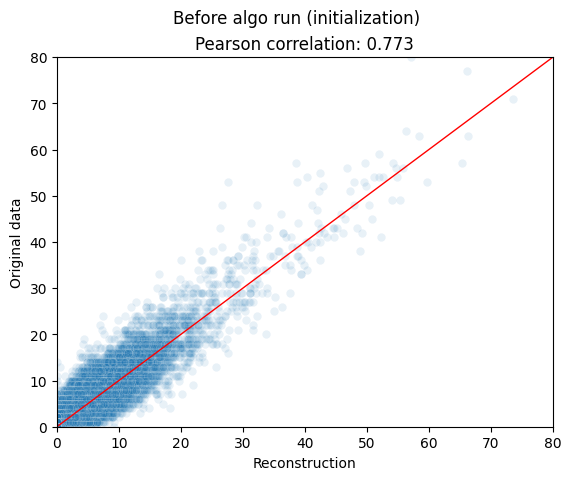

In [81]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_3b5@H0_3b5), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [72]:
spearmanr(np.maximum(0, W0_3b5@H0_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.44907951750884095, pvalue=0.0)

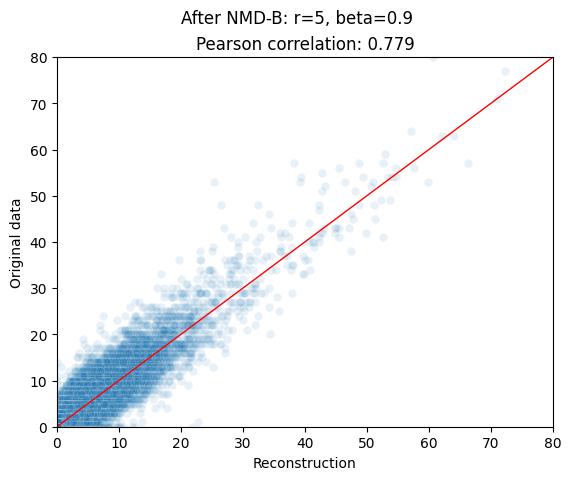

In [82]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b5), X_nmd, "After NMD-B: r=5, beta=0.9", type="scatter", sample_fraction=None)

In [71]:
spearmanr(np.maximum(0, Theta_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46873807071978274, pvalue=0.0)

## A-NMD Search

In [86]:
k_devs, opt_k_anmd = cs.select_anmd_params_countsplit(data_train, data_test, potential_ks=ks_2_check, layer=data_layer, beta=0.9, do_warmstart=True)

################## LATENT DIM 15
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 71.015087] - 0.565136 secs
[1 : 71.889808] - 0.557574 secs
[2 : 79.040390] - 0.694410 secs
[3 : 70.629938] - 0.693447 secs
[4 : 69.904231] - 0.694886 secs
[5 : 69.630260] - 0.690049 secs
[6 : 69.471652] - 0.702672 secs
[7 : 69.368590] - 0.702217 secs
[8 : 69.319047] - 0.700856 secs
[9 : 69.275962] - 0.697219 secs
[10 : 69.196781] - 0.698456 secs
[11 : 69.145319] - 0.694710 secs
[12 : 69.100602] - 0.702202 secs
[13 : 69.055471] - 0.699282 secs
[14 : 69.010266] - 0.694354 secs
[15 : 68.974416] - 0.695862 secs
[16 : 68.975295] - 0.690978 secs
[17 : 68.952576] - 0.693326 secs
[18 : 68.932990] - 0.699388 secs
[19 : 68.914438] - 0.693137 secs
[20 : 68.896032] - 0.695195 secs
[21 : 68.877868] - 0.696333 secs
[22 : 68.863136] - 0.695120 secs
[23 : 68.853520] - 0.695536 secs
[24 : 68.850758] - 0.691651 secs
[25 : 68.836754] - 0.689690 secs
[26 : 68.825938] - 0.692835 s

[0 : 82.587908] - 0.563760 secs
[1 : 83.149556] - 0.556667 secs
[2 : 91.622878] - 0.693744 secs
[3 : 79.579247] - 0.698574 secs
[4 : 78.576091] - 0.694436 secs
[5 : 78.209876] - 0.695213 secs
[6 : 78.068387] - 0.693687 secs
[7 : 78.012740] - 0.688876 secs
[8 : 77.990606] - 0.692446 secs
[9 : 77.981780] - 0.693146 secs
[10 : 77.978254] - 0.688071 secs
[11 : 77.976844] - 0.689209 secs
[12 : 77.976280] - 0.693289 secs
[13 : 77.976055] - 0.693705 secs
[14 : 77.975964] - 0.690721 secs
[15 : 77.975928] - 0.690742 secs
[16 : 77.975914] - 0.691174 secs
[17 : 77.975908] - 0.691194 secs
[18 : 77.975906] - 0.694201 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 77.97590493006578%, after 20 iterations.
Initialization time: 0.149257 secs
Mean time per iteration: 0.678571 secs
Total time: 13.042111 secs

################## LATENT DIM 4
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 85.152670] - 0.522853 secs
[1 : 9

In [87]:
opt_k_anmd

2

In [88]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0_anmd, H0_anmd = cs.nuclear_norm_init(X_nmd, m, n, opt_k_anmd)
Theta0_anmd = W0_anmd @ H0_anmd

In [89]:
Theta_anmd, loss_anmd, iters_anmd, times_anmd = nmd.a_nmd(X_nmd, r=opt_k_anmd, Theta0=Theta0_anmd, beta=0.9, tol_over_10iters=1e-5)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 65.153374] - 0.509614 secs
[1 : 65.564678] - 0.503634 secs
[2 : 67.944528] - 0.636612 secs
[3 : 64.807652] - 0.629330 secs
[4 : 64.138997] - 0.635477 secs
[5 : 63.508994] - 0.577986 secs
[6 : 62.928089] - 0.572735 secs
[7 : 62.594460] - 0.635329 secs
[8 : 62.483329] - 0.647450 secs
[9 : 62.420738] - 0.582740 secs
[10 : 62.377222] - 0.580085 secs
[11 : 62.357002] - 0.636295 secs
[12 : 62.345551] - 0.647996 secs
[13 : 62.339811] - 0.641618 secs
[14 : 62.333916] - 0.585074 secs
[15 : 62.329711] - 0.579013 secs
[16 : 62.326967] - 0.628521 secs
[17 : 62.324326] - 0.642129 secs
[18 : 62.321860] - 0.580517 secs
[19 : 62.319591] - 0.579871 secs
[20 : 62.317538] - 0.630994 secs
[21 : 62.315661] - 0.647880 secs
[22 : 62.314076] - 0.581502 secs
[23 : 62.312840] - 0.575844 secs
[24 : 62.312069] - 0.640791 secs
[25 : 62.311761] - 0.631647 secs
[26 : 62.311236] - 0.639987 secs
[27 : 62.310834] - 0.575910 s

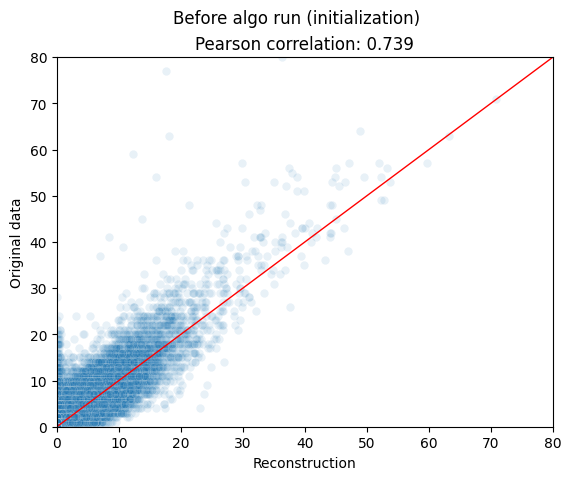

In [90]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0_anmd), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [91]:
spearmanr(np.maximum(0, Theta0_anmd).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4231025426184257, pvalue=0.0)

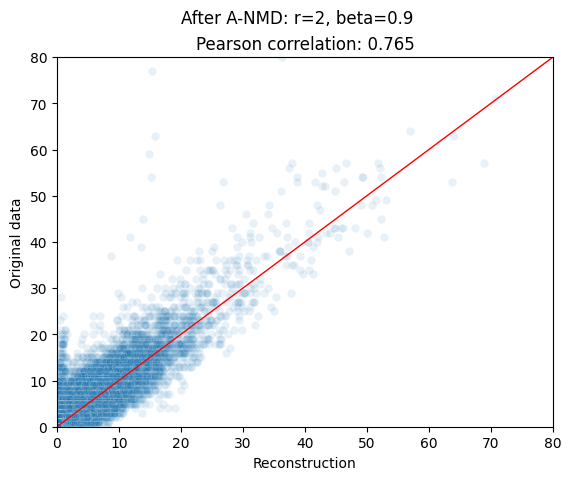

In [92]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_anmd), X_nmd, "After A-NMD: r=2, beta=0.9", type="scatter", sample_fraction=None)

In [93]:
spearmanr(np.maximum(0, Theta_anmd).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46135073573624696, pvalue=0.0)

## A-NMD with beta 0

In [98]:
k_devs_beta0, opt_k_anmd_beta0 = cs.select_anmd_params_countsplit(data_train, data_test, potential_ks=ks_2_check, layer=data_layer, beta=0.0, do_warmstart=False)

################## LATENT DIM 15
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 70.332257] - 0.564645 secs
[1 : 69.708118] - 0.560853 secs
[2 : 69.450892] - 0.694857 secs
[3 : 69.312015] - 0.690358 secs
[4 : 69.222342] - 0.696688 secs
[5 : 69.158724] - 0.699248 secs
[6 : 69.110513] - 0.695212 secs
[7 : 69.072463] - 0.699229 secs
[8 : 69.042160] - 0.701146 secs
[9 : 69.017842] - 0.695934 secs
[10 : 68.998183] - 0.693250 secs
[11 : 68.982033] - 0.701374 secs
[12 : 68.968616] - 0.693519 secs
[13 : 68.957364] - 0.690213 secs
[14 : 68.947742] - 0.693179 secs
[15 : 68.939391] - 0.691393 secs
[16 : 68.932031] - 0.690500 secs
[17 : 68.925364] - 0.690662 secs
[18 : 68.919230] - 0.691497 secs
[19 : 68.913601] - 0.684318 secs
[20 : 68.908367] - 0.695946 secs
[21 : 68.903503] - 0.689474 secs
[22 : 68.898860] - 0.692260 secs
[23 : 68.894483] - 0.691829 secs
[24 : 68.890182] - 0.685367 secs
[25 : 68.886073] - 0.692959 secs
[26 : 68.882030] - 0.690607 s

[119 : 69.546071] - 0.676146 secs
[120 : 69.545051] - 0.676486 secs
[121 : 69.544070] - 0.675930 secs
[122 : 69.543114] - 0.678672 secs
[123 : 69.542188] - 0.677299 secs
[124 : 69.541223] - 0.672816 secs
[125 : 69.540413] - 0.683644 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 69.53954821541937%, after 127 iterations.
Initialization time: 0.190248 secs
Mean time per iteration: 0.678493 secs
Total time: 85.680427 secs

################## LATENT DIM 10
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 72.027855] - 0.512584 secs
[1 : 71.415542] - 0.518461 secs
[2 : 71.173942] - 0.652902 secs
[3 : 71.045320] - 0.652798 secs
[4 : 70.960741] - 0.650224 secs
[5 : 70.899350] - 0.648913 secs
[6 : 70.852806] - 0.658379 secs
[7 : 70.817104] - 0.652440 secs
[8 : 70.789222] - 0.654845 secs
[9 : 70.767313] - 0.650325 secs
[10 : 70.749778] - 0.655228 secs
[11 : 70.735434] - 0.660718 secs
[12 : 70.723260] - 0.652341 s

[7 : 72.086528] - 0.653673 secs
[8 : 72.056644] - 0.649565 secs
[9 : 72.034538] - 0.645463 secs
[10 : 72.017815] - 0.653971 secs
[11 : 72.004662] - 0.649462 secs
[12 : 71.994133] - 0.646876 secs
[13 : 71.985478] - 0.643917 secs
[14 : 71.978233] - 0.646533 secs
[15 : 71.972085] - 0.644187 secs
[16 : 71.966726] - 0.643067 secs
[17 : 71.962020] - 0.640375 secs
[18 : 71.957738] - 0.647371 secs
[19 : 71.953793] - 0.644995 secs
[20 : 71.950051] - 0.645947 secs
[21 : 71.946479] - 0.642064 secs
[22 : 71.943028] - 0.644530 secs
[23 : 71.939599] - 0.649255 secs
[24 : 71.936168] - 0.643571 secs
[25 : 71.932677] - 0.644536 secs
[26 : 71.929137] - 0.643007 secs
[27 : 71.925456] - 0.643583 secs
[28 : 71.921658] - 0.647962 secs
[29 : 71.917674] - 0.646684 secs
[30 : 71.913513] - 0.644674 secs
[31 : 71.909120] - 0.643598 secs
[32 : 71.904407] - 0.644182 secs
[33 : 71.899427] - 0.643491 secs
[34 : 71.894161] - 0.642754 secs
[35 : 71.888529] - 0.642464 secs
[36 : 71.882588] - 0.642719 secs
[37 : 71.8763

[24 : 73.006376] - 0.689495 secs
[25 : 72.997608] - 0.686036 secs
[26 : 72.988018] - 0.688338 secs
[27 : 72.977532] - 0.687593 secs
[28 : 72.966070] - 0.681772 secs
[29 : 72.953573] - 0.691141 secs
[30 : 72.939932] - 0.696860 secs
[31 : 72.925133] - 0.693009 secs
[32 : 72.909175] - 0.686650 secs
[33 : 72.892092] - 0.686349 secs
[34 : 72.873937] - 0.685212 secs
[35 : 72.854835] - 0.685317 secs
[36 : 72.834943] - 0.685319 secs
[37 : 72.814566] - 0.687875 secs
[38 : 72.794078] - 0.684753 secs
[39 : 72.773838] - 0.696712 secs
[40 : 72.754242] - 0.695128 secs
[41 : 72.735626] - 0.731456 secs
[42 : 72.718267] - 0.704356 secs
[43 : 72.702402] - 0.690474 secs
[44 : 72.688148] - 0.683351 secs
[45 : 72.675480] - 0.689702 secs
[46 : 72.664330] - 0.682615 secs
[47 : 72.654523] - 0.694047 secs
[48 : 72.645885] - 0.695715 secs
[49 : 72.638364] - 0.690770 secs
[50 : 72.631785] - 0.688056 secs
[51 : 72.625986] - 0.692102 secs
[52 : 72.620824] - 0.692182 secs
[53 : 72.616195] - 0.690691 secs
[54 : 72.6

[47 : 75.757761] - 0.620257 secs
[48 : 75.756951] - 0.620714 secs
[49 : 75.756188] - 0.623013 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 75.75546511699451%, after 51 iterations.
Initialization time: 0.186213 secs
Mean time per iteration: 0.618353 secs
Total time: 31.103872 secs

################## LATENT DIM 1
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 84.921127] - 0.514415 secs
[1 : 80.578900] - 0.514360 secs
[2 : 78.933505] - 0.646267 secs
[3 : 78.389136] - 0.648202 secs
[4 : 78.195144] - 0.646873 secs
[5 : 78.111698] - 0.645694 secs
[6 : 78.064545] - 0.651064 secs
[7 : 78.033183] - 0.654256 secs
[8 : 78.013285] - 0.649307 secs
[9 : 78.000092] - 0.645298 secs
[10 : 77.990801] - 0.649898 secs
[11 : 77.984528] - 0.646749 secs
[12 : 77.979924] - 0.652706 secs
[13 : 77.976641] - 0.645417 secs
[14 : 77.973920] - 0.647527 secs
[15 : 77.971456] - 0.645646 secs
[16 : 77.969351] - 0.646865 secs
[17 :

In [99]:
opt_k_anmd_beta0

2

In [101]:
Theta_anmd0, loss_anmd0, iters_anmd0, times_anmd0 = nmd.a_nmd(X_nmd, r=opt_k_anmd_beta0, Theta0=Theta0_anmd, beta=0.0, tol_over_10iters=1e-5)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 64.388509] - 0.505708 secs
[1 : 63.608260] - 0.504581 secs
[2 : 63.018562] - 0.642668 secs
[3 : 62.654754] - 0.640500 secs
[4 : 62.489040] - 0.642436 secs
[5 : 62.421864] - 0.644046 secs
[6 : 62.393088] - 0.652412 secs
[7 : 62.377025] - 0.646496 secs
[8 : 62.365414] - 0.643282 secs
[9 : 62.356321] - 0.645305 secs
[10 : 62.349237] - 0.647540 secs
[11 : 62.343439] - 0.646818 secs
[12 : 62.338682] - 0.642390 secs
[13 : 62.334794] - 0.643595 secs
[14 : 62.331534] - 0.649872 secs
[15 : 62.328776] - 0.647536 secs
[16 : 62.326424] - 0.657376 secs
[17 : 62.324399] - 0.649880 secs
[18 : 62.322683] - 0.717284 secs
[19 : 62.321204] - 0.638300 secs
[20 : 62.319950] - 0.645120 secs
[21 : 62.318842] - 0.641770 secs
[22 : 62.317866] - 0.635791 secs
[23 : 62.316990] - 0.637473 secs
[24 : 62.316207] - 0.642337 secs
[25 : 62.315504] - 0.637036 secs
[26 : 62.314880] - 0.638463 secs
[27 : 62.314325] - 0.638417 s

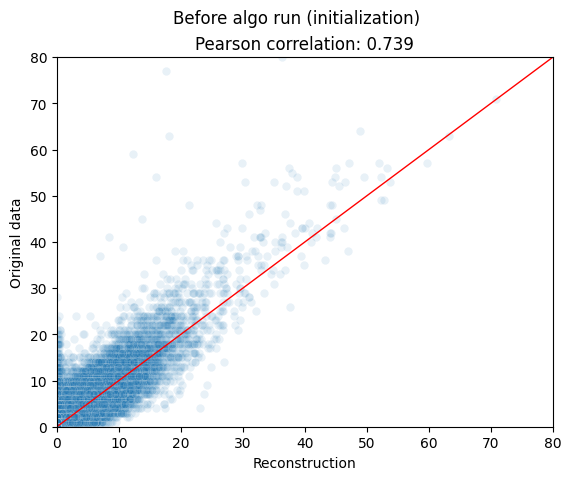

In [102]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0_anmd), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [103]:
spearmanr(np.maximum(0, Theta0_anmd).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4231025426184257, pvalue=0.0)

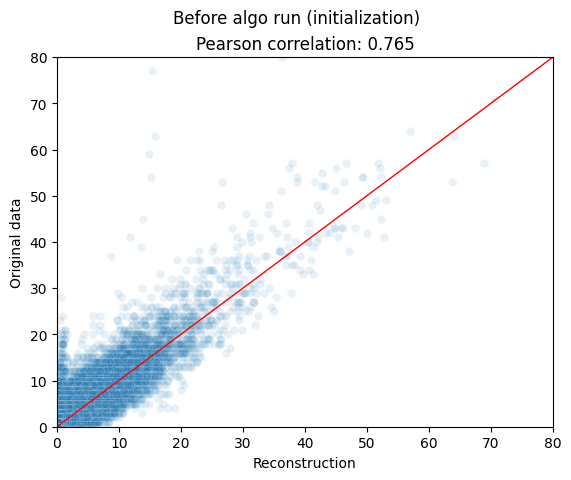

In [104]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_anmd0), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [105]:
spearmanr(np.maximum(0, Theta_anmd0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46135590953166883, pvalue=0.0)